In [ ]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define the environment
class TaskOffloadingEnv(gym.Env):
    def __init__(self, n_vehicles, F_RSU=10e9, F_C=20e9, max_steps=100):
        super(TaskOffloadingEnv, self).__init__()
        self.n = n_vehicles
        self.F_RSU = F_RSU
        self.F_C = F_C
        self.max_steps = max_steps
        self.current_step = 0

        self.action_space = spaces.Tuple((
            spaces.MultiBinary(self.n),
            spaces.Box(low=1e9, high=2e9, shape=(self.n,), dtype=np.float32),
            spaces.Box(low=2e9, high=4e9, shape=(self.n,), dtype=np.float32)
        ))

        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(12 * self.n,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.d_V = np.random.randint(31000, 31010, self.n) * 8
        self.c_V = np.random.randint(5, 6, self.n) * 1e3 / 8
        self.tau_V = np.random.randint(5, 6, self.n)
        self.bar_d_V = np.random.randint(15500, 15510, self.n) * 8
        self.f_V = np.random.randint(1, 2, self.n) * 1e9
        self.T_upload_RSU = np.random.randint(20, 21, self.n) * 1e6
        self.T_download_RSU = np.random.randint(40, 41, self.n) * 1e6
        self.T_upload_C = np.random.randint(20, 21, self.n) * 1e7
        self.T_download_C = np.random.randint(40, 41, self.n) * 1e7
        self.T_b = np.random.randint(100, 101, self.n) * 1e6
        self.v_V = np.random.randint(20, 21, self.n)
        self.R = np.random.randint(1000, 1001, self.n)

        return np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, 
                               self.T_upload_RSU, self.T_download_RSU, self.T_upload_C, 
                               self.T_download_C, self.T_b, self.v_V, self.R])

    def step(self, action):
        self.current_step += 1

        x_V, F_RSU_V, F_C_V = action 
        x_V = x_V.reshape(-1)  # Flatten the action array if necessary
        F_RSU_V = F_RSU_V.flatten()
        F_C_V = F_C_V.flatten()

        T_total = 0
        tau_total = 0
        T_V_edge = 0
        counter = 0
        for i in range(self.n):
            tau_total += self.tau_V[i]
            T_V_j = (self.d_V[i] / self.T_upload_RSU[i]) + ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + (self.bar_d_V[i] / self.T_download_RSU[i]) + 2*0.003*1e-3
            if x_V[i] == 0:  # use local
                T_V_i = (self.d_V[i] * self.c_V[i]) / self.f_V[i]
            else:
                if (self.v_V[i] * T_V_j) <= self.R[i]:  # within range use edge
                    counter += 1
                    T_V_i = T_V_j
                else:  # beyond range use cloud
                    T_V_i = (self.d_V[i] / self.T_upload_C[i]) + ((self.d_V[i] * self.c_V[i]) / (F_C_V[i])) + (self.bar_d_V[i] / self.T_download_C[i]) + 2*0.3*1e-3
                    
            T_total += T_V_i

        x_V = torch.as_tensor(x_V, dtype=torch.float32)
        F_RSU_V = torch.as_tensor(F_RSU_V, dtype=torch.float32)
        F_C_V = torch.as_tensor(F_C_V, dtype=torch.float32)

        if torch.sum(x_V * counter * F_RSU_V) > self.F_RSU or torch.sum(x_V * (self.n - counter) * F_C_V) > self.F_C or (T_total > tau_total):
            reward = -1e11
        else:
            reward = -T_total

        next_state = np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_upload_C, self.T_download_C, self.T_b, self.v_V, self.R])

        done = self.current_step >= self.max_steps

        return next_state, reward, done, {}

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, std=0.2):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.actor_fc = nn.Linear(hidden_size, num_actions)  # Discrete x action probabilities
        self.actor_fc3 = nn.Linear(hidden_size, num_actions)  # Continuous action means2
        self.actor_fc4 = nn.Linear(hidden_size, num_actions)  # Continuous action means3

        self.critic = nn.Linear(hidden_size, 1)

        self.log_std = nn.Parameter(torch.ones(1, num_actions) * std)
        
    def forward(self, x):
        x = self.common(x)

        probs = torch.sigmoid(self.actor_fc(x))  # Discrete action probabilities sigmoid gives 0 1 
        means2 = self.actor_fc3(x)  # Continuous action2 means
        stds2 = self.log_std.expand_as(means2)
        means3 = self.actor_fc4(x)  # Continuous action3 means
        stds3 = self.log_std.expand_as(means3)

        value = self.critic(x)

        return probs, means2, stds2, means3, stds3, value

def compute_returns(next_value, rewards, masks, gamma):
    R1 = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R1 = rewards[step] + gamma * R1 * masks[step]
        returns.insert(0, R1)
    return returns

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, entropy_coefficient, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist_probs, means2, stds2, means3, stds3, value = model(state)

            action_continuous2 = action[:, n_vehicles:2*n_vehicles]
            action_continuous3 = action[:, 2*n_vehicles:]
            dist_normal2 = Normal(means2, stds2)
            dist_normal3 = Normal(means3, stds3)
            new_log_prob_continuous2 = dist_normal2.log_prob(action_continuous2).sum(1, keepdim=True)
            new_log_prob_continuous3 = dist_normal3.log_prob(action_continuous3).sum(1, keepdim=True)

            action_discrete = action[:, :n_vehicles]
            dist_categorical = Categorical(logits=dist_probs)

            action_discrete_i_list = []
            new_log_prob_discrete_list = []
            for i in range(n_vehicles):
                action_discrete_i = action_discrete[:, i]
                action_discrete_i_list.append(action_discrete_i.unsqueeze(-1))
                new_log_prob_discrete_i = dist_categorical.log_prob(action_discrete_i)
                new_log_prob_discrete_list.append(new_log_prob_discrete_i.unsqueeze(-1))

            new_action_discrete_i = torch.cat(action_discrete_i_list, dim=-1)
            new_log_prob_discrete_i = torch.cat(new_log_prob_discrete_list, dim=-1)

            new_log_probs = new_log_prob_discrete_i + new_log_prob_continuous2 + new_log_prob_continuous3

            ratio = (new_log_probs / (old_log_probs))
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            optimizer.zero_grad()
            entropy = dist_categorical.entropy().mean() + dist_normal2.entropy().mean() + dist_normal3.entropy().mean()
            total_loss = actor_loss + 0.5 * critic_loss - entropy_coefficient * entropy
            total_loss.backward()

            max_norm = 0.5
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

def evaluate_policy(env, model, n_vehicles, episodes=2):
    total_latency = 0.0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist_probs, means2, stds2, means3, stds3, _ = model(state)
                if torch.isnan(dist_probs).any() or torch.isnan(means2).any() or torch.isnan(stds2).any() or torch.isnan(means3).any() or torch.isnan(stds3).any():
                    print("NaN detected in output of model")
                    continue
                action_cat = Categorical(dist_probs)
                action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
                action_discrete = action_discrete.reshape(1, n_vehicles)
                action_continuous2 = Normal(means2, stds2).sample()
                action_continuous3 = Normal(means3, stds3).sample()

                action = (action_discrete, action_continuous2.numpy(), action_continuous3.numpy())
            next_state, reward, done, _ = env.step(action)
            total_latency += -reward
            state = next_state

    average_latency = total_latency / episodes
    return average_latency

def run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma):
    env = TaskOffloadingEnv(n_vehicles=n_vehicles)
    num_inputs = env.observation_space.shape[0]
    num_actions = n_vehicles
    minimum_batch_size = 64

    model = ActorCritic(num_inputs, num_actions, hidden_size=512)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    max_frames = 1000
    frame_idx = 0
    latencies = []
    epochs_recorded = []

    state = env.reset()
    best_latency = float('inf')

    while frame_idx < max_frames:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []

        for _ in range(100):
            state = torch.FloatTensor(state).unsqueeze(0)
            dist_probs, means2, stds2, means3, stds3, value = model(state)
            
            dist_probs = dist_probs.squeeze(0)
            action_cat = Categorical(logits=dist_probs)
            action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
            action_discrete = action_discrete.reshape(1, n_vehicles)

            action_continuous2 = Normal(means2, stds2).sample()
            action_continuous2_np = action_continuous2.numpy()
            
            action_continuous3 = Normal(means3, stds3).sample()
            action_continuous3_np = action_continuous3.numpy()
            
            action = (action_discrete, action_continuous2_np, action_continuous3_np)
            
            next_state, reward, done, _ = env.step(action)
            log_prob = action_cat.log_prob(action_discrete) + Normal(means2, stds2).log_prob(action_continuous2).sum(1, keepdim=True) + Normal(means3, stds3).log_prob(action_continuous3).sum(1, keepdim=True)
            
            states.append(state)
            actions.append(torch.cat([action_discrete, action_continuous2, action_continuous3], 1))
            rewards.append(reward)
            masks.append(1 - done)
            values.append(value)
            log_probs.append(log_prob)

            state = next_state
            frame_idx += 1

            if done:
                state = env.reset()

        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, _, _, _, _, next_value = model(next_state)
            
        returns = compute_returns(next_value, rewards, masks, gamma)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values
        ppo_epoch = 4
        ppo_update(model, optimizer, ppo_epoch, minimum_batch_size, states, actions, log_probs, returns, advantage, entropy_coefficient)

        if frame_idx % 100 == 0:
            latency = evaluate_policy(env, model, n_vehicles)
            latencies.append(latency)
            epochs_recorded.append(frame_idx)
            avg_latency = np.mean(latencies[-100:])
            if avg_latency <= best_latency:
                best_latency = avg_latency

    config_label = f'n={n_vehicles}, lr={learning_rate}, hcoeff={entropy_coefficient}, gamma={gamma}'
    data = pd.DataFrame({
    'Iteration': epochs_recorded,
    'Latency at ' + config_label: latencies
    })
    all_results.append(data)

all_results = []
n_vehicles_options = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
best_configs = {
    10: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    20: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    30: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    40: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    50: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    60: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    70: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    80: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    90: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)],
    100: [(0.003, 0.01, 0.4),(0.003, 0.08, 0.4),(0.003, 0.01, 0.9),(0.003, 0.08, 0.9),(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.01, 0.9),(0.0003, 0.08, 0.9)]
}
    #10: [(0.0003, 0.01, 0.4),(0.0003, 0.08, 0.4),(0.0003, 0.08, 0.9)],
    #50: [(0.003, 0.01, 0.4), (0.003, 0.08, 0.4),(0.0003, 0.08, 0.9)],
    #100: [(0.0003, 0.08, 0.4)]


for n_vehicles in n_vehicles_options:
    for config in best_configs[n_vehicles]:
        learning_rate, entropy_coefficient, gamma = config
        print(f'Starting experiment with {n_vehicles} vehicles, learning rate {learning_rate}, '
              f'entropy coefficient {entropy_coefficient}, and discount factor {gamma}')
        run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma)

combined_results = pd.concat(all_results)
file_path = 'latency_vs_vehicles_hybrid_delay_vs_n.csv'
combined_results.to_csv(file_path, index=False)



   Vehicles  Latency (ms)
0        10  3.693750e+12
1        20  6.356875e+12
2        30  4.238125e+12
3        40  5.734375e+12
4        50  4.225000e+12
5        60  6.673125e+12
6        70  7.274375e+12
7        80  7.740625e+12
8        90  8.228750e+12
9       100  4.029375e+12


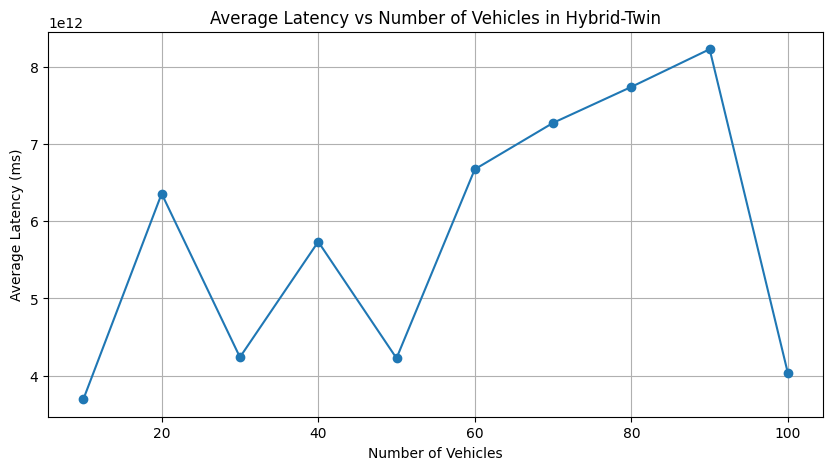

In [3]:
# Extract the number of vehicles from the column names
combined_results_melted = combined_results.melt(id_vars=['Iteration'], var_name='Configuration', value_name='Latency (ms)')
combined_results_melted['Vehicles'] = combined_results_melted['Configuration'].str.extract(r'n=(\d+)').astype(int)

# Group by the number of vehicles and calculate the average latency
average_latencies = combined_results_melted.groupby('Vehicles')['Latency (ms)'].mean().reset_index()

print(average_latencies)
plt.figure(figsize=(10, 5))
plt.plot(average_latencies['Vehicles'], average_latencies['Latency (ms)'], marker='o')
plt.title("Average Latency vs Number of Vehicles in Hybrid-Twin")
plt.xlabel("Number of Vehicles")
plt.ylabel("Average Latency (ms)")
plt.grid(True)
plt.show()